In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 보조 데이터 Set
age_gender = pd.read_csv("../data/age_gender_bkts.csv")
countries = pd.read_csv("../data/countries.csv")
sessions = pd.read_csv("../data/sessions.csv")

In [4]:
train = pd.read_csv("../data/train_users_2.csv")
test = pd.read_csv("../data/test_users.csv")
ss = pd.read_csv("../data/sample_submission_NDF.csv")

In [5]:
# train / test columns 비교
set(train.columns) - set(test.columns)

{'country_destination'}

In [6]:
train.shape, test.shape

((213451, 16), (62096, 15))

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [8]:
train.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [9]:
for col in train.columns:
    print("{col} : {count}".format(col=col, count=len(train[col].unique())))

id : 213451
date_account_created : 1634
timestamp_first_active : 213451
date_first_booking : 1977
gender : 4
age : 128
signup_method : 3
signup_flow : 17
language : 25
affiliate_channel : 8
affiliate_provider : 18
first_affiliate_tracked : 8
signup_app : 4
first_device_type : 9
first_browser : 52
country_destination : 12


In [23]:
train.tail()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF
213450,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF


## 1. Target (Destination) 탐색

In [11]:
print(train['country_destination'].unique())

['NDF' 'US' 'other' 'FR' 'CA' 'GB' 'ES' 'IT' 'PT' 'NL' 'DE' 'AU']


In [13]:
# 나라별로 Count 
data1 = train.groupby('country_destination').aggregate({'id':'count'}).reset_index()
data1.sort_values(by=['id'], ascending=False)

,country_destination,id
7,NDF,124543
10,US,62376
11,other,10094
4,FR,5023
6,IT,2835
5,GB,2324
3,ES,2249
1,CA,1428
2,DE,1061
8,NL,762


Countries Category가 12개

예외 1) NDF : Do Not Make a booking (58.35%)
 
예외 2) others : 4.7%

In [14]:
124543/213451, 10094/213451

(0.5834734904029496, 0.04728954186206671)

### 1.1 여행지 비율

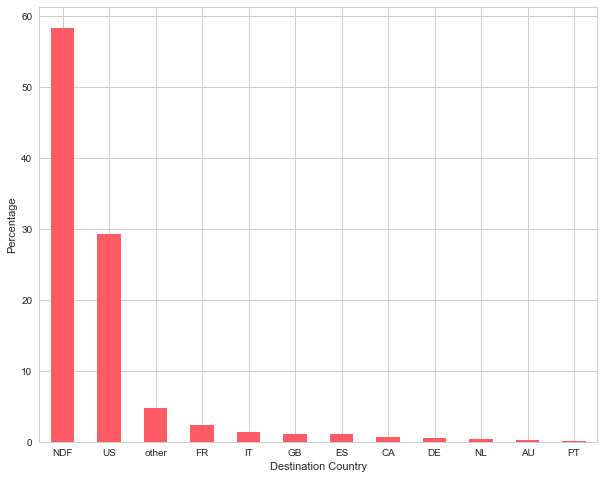

In [14]:
plt.figure(figsize=(10,8))
destination_percentage = train.country_destination.value_counts() / train.shape[0] * 100
destination_percentage.plot(kind='bar',color='#FD5C64', rot=0)


plt.xlabel('Destination Country')
plt.ylabel('Percentage')
plt.show()

## 2. Gender Column 탐색

In [15]:
data2 = train.groupby('gender').aggregate({'id':'count'}).reset_index()
data2.sort_values(by=['id'], ascending=False)

,gender,id
0,-unknown-,95688
1,FEMALE,63041
2,MALE,54440
3,OTHER,282


unknown 값을 어떻게 처리할까?

idea1) train data의 나이를 참조해서 age_gender의 나이대에 성별을 랜덤하게 입력?

idea2) 성별이 영향이 있을까? 동반자 데이터가 없는데. 혼자가 아닌 이상 영향이 없을 것 같다는 생각도 듬 : age_gender 데이터를 통해 극명하게 성별에 따른 우위가 있는 여행지가 있는지 확인

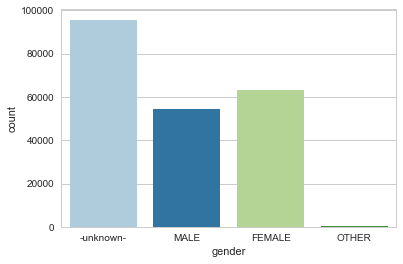

In [16]:
sns.countplot(x=train.gender, palette='Paired')
plt.show()

### 2.1 성별에 따른 여행지 선호도가 달라질까?

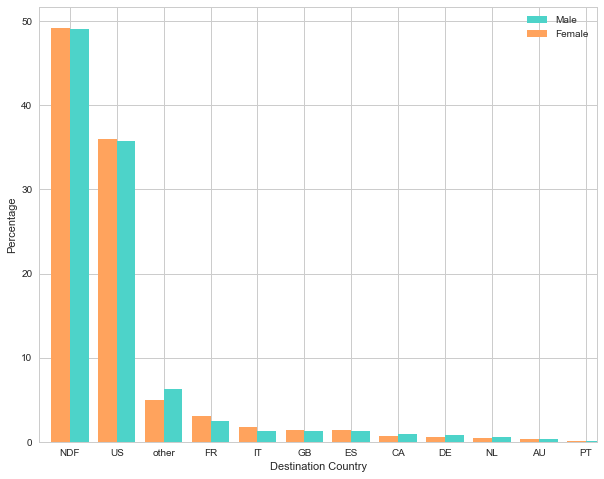

In [17]:
female_destinations = train.loc[train['gender'] == 'FEMALE', 'country_destination'].value_counts() / sum(train['gender'] == 'FEMALE') * 100
male_destinations = train.loc[train['gender'] == 'MALE', 'country_destination'].value_counts() / sum(train['gender'] == 'MALE') * 100

plt.figure(figsize=(10,8))
male_destinations.plot(kind='bar', width=0.4, color='#4DD3C9', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=0.4, color='#FFA35D', position=1, label='Female', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')


plt.show()

프랑스, 이탈리아, 영국: 여성 선호 (패션, 아름다움)

캐나다, 독일, 네덜란드 : 남성선호 (Extrme, 맥주, 성, 축구)

## 3. Age Column 탐색

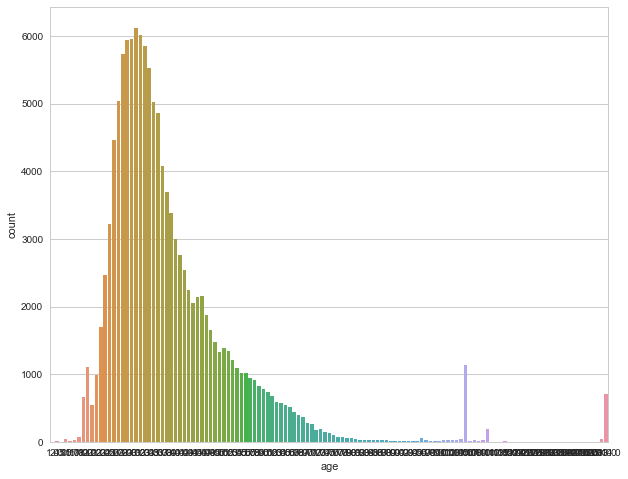

In [22]:
plt.figure(figsize=(10,8))

sns.countplot(x=train.age.dropna())
plt.show()

In [42]:
younger = sum(train.loc[train['age'] < 30, 'country_destination'].value_counts())
family = sum(train.loc[train['age'] > 30 | train['age'] < 60, 'country_destination'].value_counts())
older = sum(train.loc[train['age'] > 60, 'country_destination'].value_counts())

younger_destinations = train.loc[train['age'] < 30, 'country_destination'].value_counts() / younger * 100
family_destinations = train.loc[train['age'] > 30 | train.loc[train['age'] < 60, 'country_destination'].value_counts() / family * 100
older_destinations = train.loc[train['age'] > 60, 'country_destination'].value_counts() / older * 100

plt.figure(figsize=(10,8))
younger_destinations.plot(kind='bar', width=0.4, color='r', position=0, label='Youngers', rot=0)
family_destinations.plot(kind='bar', width=0.4, color='b', position=1, label='Family', rot=0)
older_destinations.plot(kind='bar', width=0.4, color='g', position=2, label='Olders', rot=0)


plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

plt.show()


SyntaxError: invalid syntax (<ipython-input-42-d146ccacc816>, line 7)

In [47]:
data3 = train[train.age > 100]
data3

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,-unknown-,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
398,9ouah6tc30,2010-04-12,20100412231534,2010-04-12,FEMALE,104.0,facebook,3,en,other,craigslist,linked,Web,iPhone,Mobile Safari,FR
627,dc3udjfdij,2010-05-19,20100519012455,2010-06-16,-unknown-,105.0,basic,2,en,other,craigslist,omg,Web,Mac Desktop,Safari,FR
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
1190,qc9se9qucz,2010-07-27,20100727002029,2010-07-27,-unknown-,105.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Firefox,US
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US
1208,cguxptdi6h,2010-07-28,20100728034415,2010-07-28,-unknown-,105.0,basic,3,en,direct,direct,untracked,Web,Mac Desktop,Firefox,US
1239,6vpmryt377,2010-07-30,20100730055204,2010-07-30,FEMALE,2014.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,CA


In [49]:
data3_1 = data3.groupby('age').aggregate({'id':'count'}).reset_index()
data3_1

,age,id
0,101.0,23
1,102.0,34
2,103.0,26
3,104.0,48
4,105.0,1131
5,106.0,17
6,107.0,23
7,108.0,15
8,109.0,31
9,110.0,196


기네스북 최고령자는 146세, 가장 최근은 116세

1924~2008은 생년월일을 잘못 입력한 듯

2013, 2014는 해당년도로 잘못분류 된듯

나이 데이터는 중요할 것으로 판단되는데... 어떻게 처리할지...

## 4. date_first_booking 데이터 

In [52]:
train.date_first_booking.isnull().sum()

124543

In [51]:
train[train.date_first_booking.notnull()].date_first_booking.describe()

count          88908
unique          1976
top       2014-05-22
freq             248
Name: date_first_booking, dtype: object

In [50]:
data4 = train.groupby('date_first_booking').aggregate({'id':'count'}).reset_index()
data4

,date_first_booking,id
0,2010-01-02,1
1,2010-01-04,1
2,2010-01-05,1
3,2010-01-06,1
4,2010-01-08,1
5,2010-01-09,1
6,2010-01-10,1
7,2010-01-11,2
8,2010-01-13,2
9,2010-01-15,2


Null 값은 NDF 숫자와 같음

NDF를 왜 넣어뒀을까?

도착지 예측을 위해서가 아니라 그냥 마케팅적으로 이용하기위해 데이터를 다 담아둔 것을까?

## 5. Sign_up Data

In [44]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [56]:
sessions.tail()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0
10567736,9uqfg8txu3,show_personalize,data,user_profile_content_update,Windows Desktop,1221.0


In [49]:
df_signup = train.loc[:, ['gender', 'age', 'language', 'signup_method', 'signup_flow', 'signup_app', 'country_destination']]
df_signup.tail()

,gender,age,language,signup_method,signup_flow,signup_app,country_destination
213446,MALE,32.0,en,basic,0,Web,NDF
213447,-unknown-,NaN,en,basic,0,Web,NDF
213448,-unknown-,32.0,en,basic,0,Web,NDF
213449,-unknown-,NaN,en,basic,25,iOS,NDF
213450,-unknown-,NaN,en,basic,25,iOS,NDF


In [88]:
method_label = train['signup_method'].unique()
print(method_label)

['facebook' 'basic' 'google']


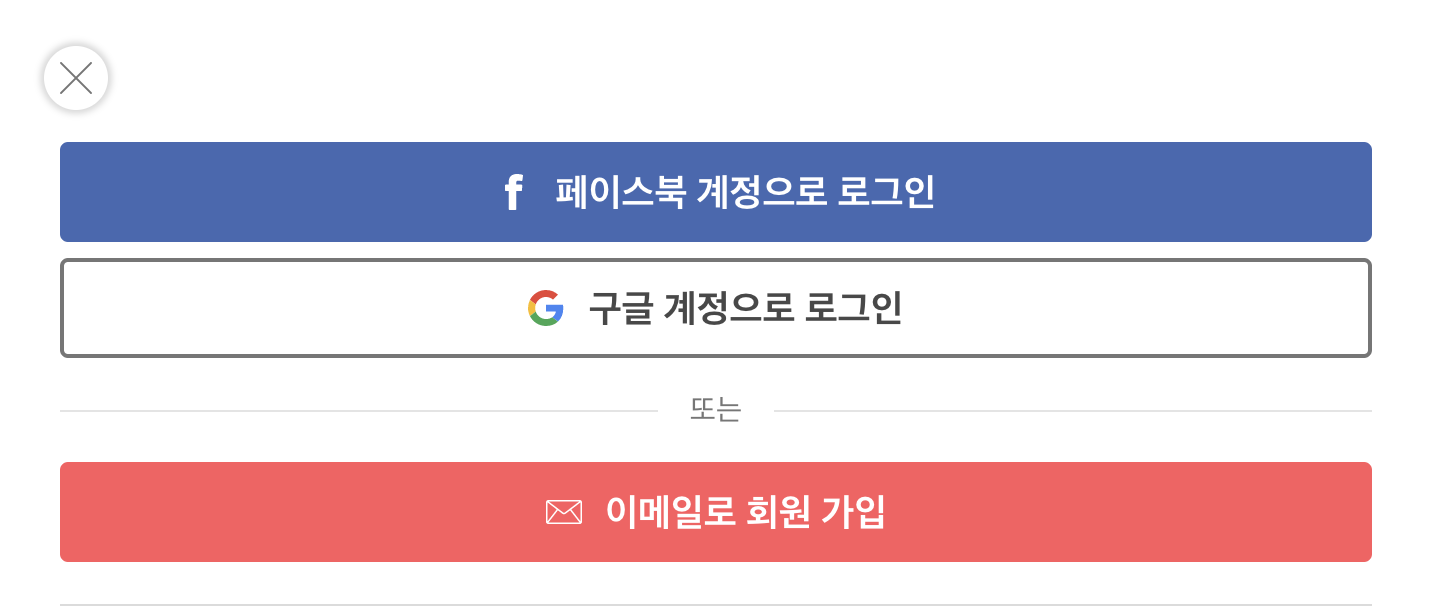

In [87]:
Image.open('sign_up.png')

In [89]:
app_label = train['signup_app'].unique()
print(app_label)

['Web' 'Moweb' 'iOS' 'Android']


In [110]:
df_signup.pivot_table('country_destination', ['signup_method', 'signup_app'], aggfunc="count")

country_destination
signup_method signup_app                     
basic         Android                    3691
              Moweb                      4655
              Web                      131237
              iOS                       13314
facebook      Android                    1217
              Moweb                      1606
              Web                       51480
              iOS                        5705
google        Android                     546

In [114]:
data5 = df_signup.groupby(['signup_method', 'country_destination']).size()
data5

signup_method  country_destination
basic          AU                       393
               CA                      1105
               DE                       737
               ES                      1601
               FR                      3767
               GB                      1727
               IT                      2147
               NDF                    87846
               NL                       560
               PT                       154
               US                     45430
               other                   7430
facebook       AU                       146
               CA                       322
               DE                       323
               ES                       646
               FR                      1253
               GB                       597
               IT                       686
               NDF                    36252
               NL                       202
               PT                        

In [120]:
data5['basic']

country_destination
AU         393
CA        1105
DE         737
ES        1601
FR        3767
GB        1727
IT        2147
NDF      87846
NL         560
PT         154
US       45430
other     7430
dtype: int64

## 6. Affiliate (제휴 마케팅)

In [51]:
df_affiliate = train.loc[:, ['gender', 'age', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'country_destination']]
df_affiliate.tail()

,gender,age,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,country_destination
213446,MALE,32.0,en,sem-brand,google,omg,NDF
213447,-unknown-,NaN,en,direct,direct,linked,NDF
213448,-unknown-,32.0,en,direct,direct,untracked,NDF
213449,-unknown-,NaN,en,other,other,tracked-other,NDF
213450,-unknown-,NaN,en,direct,direct,untracked,NDF


In [131]:
print(train['affiliate_channel'].unique())

['direct' 'seo' 'other' 'sem-non-brand' 'content' 'sem-brand'
 'remarketing' 'api']


seo : 검색최적화 / sem : 검색엔진마케팅 / content : 컨텐츠 제작광고

remarketing : 방문자 대상으로 광고

In [135]:
print("제휴마케팅 제공자 : {}".format(len(train['affiliate_provider'].unique())))
print(train['affiliate_provider'].unique())

제휴마케팅 제공자 : 18
['direct' 'google' 'other' 'craigslist' 'facebook' 'vast' 'bing' 'meetup'
 'facebook-open-graph' 'email-marketing' 'yahoo' 'padmapper' 'gsp' 'wayn'
 'naver' 'baidu' 'yandex' 'daum']


In [137]:
print("유입 경로 : {}".format(len(train['first_affiliate_tracked'].unique())))
print(train['first_affiliate_tracked'].unique())

유입 경로 : 8
['untracked' 'omg' nan 'linked' 'tracked-other' 'product' 'marketing'
 'local ops']


## 7. First Access

In [72]:
df_first = train.loc[:, ['gender', 'age', 'language', 'first_device_type', 'first_browser', 'country_destination']]
df_first.tail()

,gender,age,language,first_device_type,first_browser,country_destination
213446,MALE,32.0,en,Mac Desktop,Safari,NDF
213447,-unknown-,NaN,en,Windows Desktop,Chrome,NDF
213448,-unknown-,32.0,en,Mac Desktop,Firefox,NDF
213449,-unknown-,NaN,en,iPhone,Mobile Safari,NDF
213450,-unknown-,NaN,en,iPhone,-unknown-,NDF


In [74]:
print(train['first_device_type'].unique())

['Mac Desktop' 'Windows Desktop' 'iPhone' 'Other/Unknown'
 'Desktop (Other)' 'Android Tablet' 'iPad' 'Android Phone'
 'SmartPhone (Other)']


In [84]:
print("browser 수 : {}".format(len(train['first_browser'].unique())))
print(train['first_browser'].unique())

browser 수 : 52
['Chrome' 'IE' 'Firefox' 'Safari' '-unknown-' 'Mobile Safari'
 'Chrome Mobile' 'RockMelt' 'Chromium' 'Android Browser' 'AOL Explorer'
 'Palm Pre web browser' 'Mobile Firefox' 'Opera' 'TenFourFox' 'IE Mobile'
 'Apple Mail' 'Silk' 'Camino' 'Arora' 'BlackBerry Browser' 'SeaMonkey'
 'Iron' 'Sogou Explorer' 'IceWeasel' 'Opera Mini' 'SiteKiosk' 'Maxthon'
 'Kindle Browser' 'CoolNovo' 'Conkeror' 'wOSBrowser' 'Google Earth'
 'Crazy Browser' 'Mozilla' 'OmniWeb' 'PS Vita browser' 'NetNewsWire'
 'CometBird' 'Comodo Dragon' 'Flock' 'Pale Moon' 'Avant Browser'
 'Opera Mobile' 'Yandex.Browser' 'TheWorld Browser' 'SlimBrowser' 'Epic'
 'Stainless' 'Googlebot' 'Outlook 2007' 'IceDragon']


In [ ]:
# first_device_type_pc = pd.concat([train[train.first_device_type == "Mac Desktop"], train[train.first_device_type == "Windows Desktop"], train[train.first_device_type == "Desktop (Other)"]])
# first_device_type_pc.reset_index(drop=True, inplace=True)
# first_device_type_pc.tail(3)

In [57]:
countries.tail()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [ ]:
train Country_destination에 맞춰서 countires의 distance_km,language_levenshtein_distance

거리는 여행경비와 연관이 있기때문에 충분히 중요한 변수가 될 수 있을 것 같다.

In [63]:
import haversine

In [66]:
countries['haversine_distance'] = countries.apply(lambda r: haversine.haversine(([36.966427, -95.844030]),
                                                                  (r['lat_destination'], r['lng_destination'])), axis=1)
countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance,haversine_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00,15297.744201
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00,2828.133504
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61,7879.567727
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25,7730.723946
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06,7682.944550
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00,6883.659361
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40,8636.630704
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22,7524.320293
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45,7355.253382
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00,0.000000


In [ ]:
distance_km : 미국을 기준으로 haversine_distance를 구한것
destination_km2 : 도착지 영토 크기

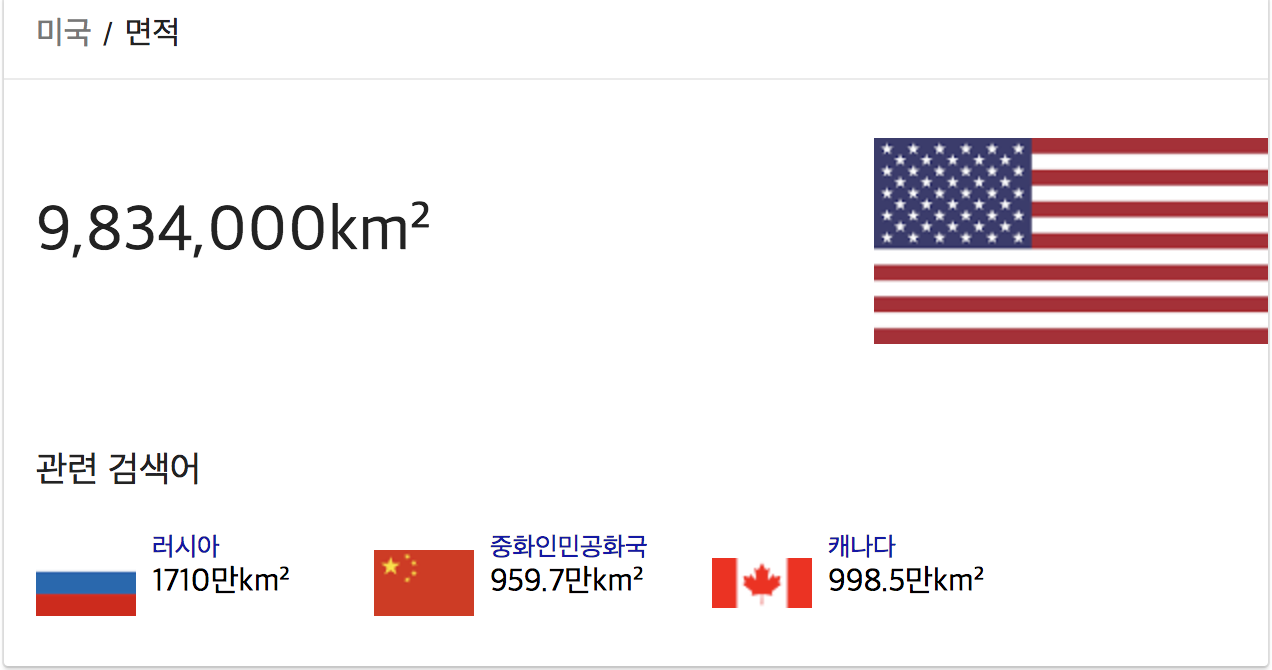

In [71]:
from PIL import Image
Image.open('destination_km2.png')

In [59]:
import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster

In [62]:
center=[np.mean(countries['lat_destination']), np.mean(countries['lng_destination'])]

m = folium.Map(
    location = center,
    zoom_start=0)


for i in range(len(countries)):
    location1=[countries.iloc[i, 1], countries.iloc[i, 2]]
    folium.CircleMarker(
        location=location1,
        radius=1,
        color = "blue"
      ).add_to(m)
    marker = folium.Marker(location=location1)
m

여기어때
전체 회원 중 구매전환율(바로예약을 의미)은 40% 정도 된다.

In [ ]:
등록일 - 첫 부킹

#### Train Data Set에서 활용할 수 있는 요소

1. 성별 / 연령 / 국적(거주지) : 언어

2. 거주지와 목적지 간 이동시간

3. 날짜정보 - 계절요인, 시기별

4. 시계열분석해서 시간에 따른 추세를 파악해볼까? (유행인 관광지)

인구ㆍ사회통계특성은 성별, 연령, 국적, 직업, 결혼, 소득, 학력, 거주지

여행특성은 동반유형, 동반자수, 여행형태, 방문유무, 방문횟수, 여행기간, 거주지와 목적지 간 이동시간

성격특성은 경험에 대한 개방성, 성실성, 외향성, 친화성, 신경증적 경향성을 포함한 세부정보 중 하나 이상을 포함하며, 

행동영향요인특성은 태도, 규범, 통제, 상황특성, 개인특성

일본: 20대(27%) 미혼(42%)이 개별여행 방식(58%)으로 방문해 놀이/테마공원/온천 등 즐기기 (20%), 휴식(18%), 식도락(17%)을 즐기고자 하는 곳.

중국: 5-60대(57%) 남성(58%)이 단체 패키지(51%)로 가서 자연 풍경 감상(34%)하고, 역사/유적 감상(23%)을 주 목적으로 하는 곳.

유럽: 경제적으로 여유 있는(월수입 7백만원 이상 36%) 시니어들이 역사/유적(36%)과 도시 경관(22%)을 감상하기 위해 패키지여행(37%)을 계획 하는 곳.

미주(미국/하와이/캐나다): 고소득(월수입 7백만원 이상 41%) 남성(53%)이 친지/친구/친척 만나기(23%), 휴식(20%), 자연 풍경 감상(20%)등의 다양한 목적을 위해 개별여행(54%)을 계획하는 곳.

대양주: 3-40대(48%) 기혼(72%) 여성(54%)이 자연 풍경 감상(32%)과 휴식(28%)을 위해 찾는 곳. 상대적으로 에어텔 패키지가 많음(19%).

홍콩/마카오: 2-30대(56%) 미혼(43%) 여성(59%)이 도시 경관 감상(28%), 쇼핑(19%), 식도락(17%)을 위해 개별여행(52%)을 계획하는 곳.